# Papers

## A quantum protocol to win the graph colouring game on all Hadamard graphs

In [1]:
from helper_functions_library.all import *
from qiskit.quantum_info import DensityMatrix

### Qiskit code simulating the steps as described exactly in the paper

The Hadamard graph $G_N$ (for $N = 4k$, for any positive integer $k$) is defined as the graph whose vertices are the set $V_N = \{0,1\}^N$, where the vertices are adjacent if and only if their Hamming distance is $N/2$.

**Quantum Fourier Transform**:

$$QFT_N\ket{j} = \frac{1}{\sqrt{N}}\sum_{k=0}^{N-1}e^{\frac{2\pi i}{N}k\cdot j}\ket{k}$$

**Phase Shift**:



They define a quantum protocol to win the graph colouring game with probability $1$ on a graph $G_N$ where $2^{n-1} < N\leq 2^n$. We will use qiskit to simulate the protocol that Alice and Bob take when they are given vertices $v_a$ and $v_b$ respectively.

For this example, we will run our code on the Hadamard graph $G_4$, using vertices $v_a = [0, 0, 0, 0]$ and $v_b = [0, 0, 1, 1]$.

v_a: (0, 0, 0, 0) 
v_b: (0, 0, 1, 1)


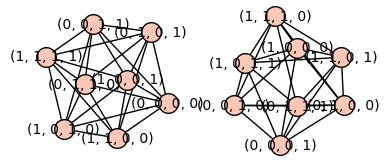

In [6]:
N = 4; n = int(np.log2(N))
G = lib_make_Hadamard(N)
va = G.vertices()[0]; vb = G.vertices()[1]
print('v_a:',va,'\nv_b:',vb)
G.show()

**Step 1**: Prepare initial state $\ket{\psi_{AB}}$

Alice and Bob prepare $2n$ qubits $\ket{0}^{\otimes n}\otimes\ket{0}^{\otimes n}$. Alice has the first $n$-qubits, and Bob has the second.

In qiskit, the order of the qubits is reversed when the circuit is displayed, so the last two player bits are Alice's, and the first two are Bob's.

In [81]:
player_reg = QuantumRegister(2**n,name="player bits"); qc_game = QuantumCircuit(player_reg,name = "Avis Game");
qc_game.draw()

player bits_0: 
               
player bits_1: 
               
player bits_2: 
               
player bits_3:

Alice applies the $QFT_N$ to her $N$-qubits:

$$\ket{0}^{\otimes n}\otimes\ket{0}^{\otimes n} \to \frac{1}{\sqrt{N}}\sum_{k=0}^{N-1}\ket{k}\otimes\ket{0}$$

In [8]:
player_reg = QuantumRegister(2**n,name="player bits"); qc_game = QuantumCircuit(player_reg,name = "Avis Game");
qft = QFTGate(n);
qc_game.append(qft,player_reg[:n])
print(qc_game)

               ┌──────┐
player bits_0: ┤0     ├
               │  Qft │
player bits_1: ┤1     ├
               └──────┘
player bits_2: ────────
                       
player bits_3: ────────
                       


Bob then applies controlled NOT operations to his $n$-qubits with Alice's qubits as control qubits for sharing the initial entanglement states:

The CNOT operation changes the target qubit if and only if the control qubit is $\ket{1}$. Since Bob's initial state of qubits are all $\ket{0}$, this means that his $j^{th}$ qubit will be the same as Alice's $j^{th}$ qubit for all $k = 0,...,n$.

$$\frac{1}{\sqrt{N}}\sum_{k=0}^{N-1}\ket{k}\otimes\ket{0} \to \frac{1}{\sqrt{N}}\sum_{k=0}^{N-1}\ket{k}\otimes\ket{k} = \ket{\psi_{AB}}$$

In [9]:
qc_game.barrier()
for j1 in range(n//2+1):
    qc_game.cx(player_reg[j1],player_reg[j1+n])
qc_game.draw()

┌──────┐ ░           
player bits_0: ┤0     ├─░───■───────
               │  Qft │ ░   │       
player bits_1: ┤1     ├─░───┼────■──
               └──────┘ ░ ┌─┴─┐  │  
player bits_2: ─────────░─┤ X ├──┼──
                        ░ └───┘┌─┴─┐
player bits_3: ─────────░──────┤ X ├
                        ░      └───┘

**Step 2**: Apply phaseshift $P_{a_i}$ and $P_{b_i}$:

This is the annoying part. Alice and Bob compute

$$(P_{a_i}\otimes P_{b_i})\ket{\psi_{AB}} = \frac{1}{\sqrt{N}}\sum_{k=0}^{N-1}(-1)^{a_i\oplus b_i}\ket{k}\otimes\ket{k}$$

Since in this case, $N = 4$, but $n = 2$, we need to find a clever way to apply the phaseshifts where we want them.

Recall that the state $\ket{00}$ is the vector $[1, 0, 0, 0]$. Similarly, $\ket{01} = [0, 1, 0, 0], \ket{10} = [0, 0, 1, 0]$, and $\ket{11} = [0, 0, 0, 1]$.

The starting states of all kets in a quantum circuit is $\ket{0}$. An "$X$ gate" is an operation that flips the state of a qubit. So applying an $X$ gate to a $\ket{0}$ will result in a $\ket{1}$, and vice versa. A "controlled gate" is a gate that only affects the "target" qubit if the "control" qubit is $\ket{1}$. So for the state $\ket{01}$, the first (control) qubit is a $\ket{0}$, and the second (target) qubit is the $\ket{1}$, so applying a controlled $X$ gate to  will result in the same $\ket{01}$, but applying it to the state $\ket{10}$ will result in the state $\ket{11}$.

We want to apply a phaseshift *only* if the state deserves it. If we want to apply the phaseshift to the state $\ket{01}$, we can flip the state of the first qubit to $\ket{1}$, and then apply a controlled $Z$ gate (the phase shift) on all the qubits. This means that the phase shift will be applied *only* if the state is $\ket{01}$.

We will go through the entries of both $v_a$ and $v_b$, and if an entry of the vector is $1$, we will apply an $X$ gate, then a controlled $Z$ gate, then another $X$ gate (to flip the state of the qubit back).

We demonstrate this below with the vector $[1, 0, 1, 0]$.





In [10]:
q_ex = QuantumCircuit(2)

#The first entry corresponds to |00>, so apply an X gate to both qubits, then a controlled Z gate, then another X gate on both qubits
q_ex.x([0])
q_ex.x([1])
q_ex.cz([0],[1])
q_ex.x([0])
q_ex.x([1])
q_ex.barrier()

#The second entry is 0, so no need to do anything

#The third entry corresponds to |10>, so apply an X gate to the first qubit, then a controlled Z gate, then another X gate on the first qubit
q_ex.x([1])
q_ex.cz([0],[1])
q_ex.x([1])

#The fourth entry is zero, so no need to do anything
q_ex.draw()

┌───┐   ┌───┐ ░              
q_0: ┤ X ├─■─┤ X ├─░───────■──────
     ├───┤ │ ├───┤ ░ ┌───┐ │ ┌───┐
q_1: ┤ X ├─■─┤ X ├─░─┤ X ├─■─┤ X ├
     └───┘   └───┘ ░ └───┘   └───┘

We will apply these gates in this manner to both Alice's and Bob's qubits.

In [18]:
player_reg = QuantumRegister(2**n,name="player bits"); qc_game = QuantumCircuit(player_reg,name = "Avis Game");
qft = QFTGate(n); qc_game.append(qft,player_reg[:n])
qc_game.barrier()
for j1 in range(n//2+1): qc_game.cx(player_reg[j1],player_reg[j1+n])
qc_game.barrier()
statelist = [] #Make a list of states 00, 01, 10, 11
for j1 in range(4): statelist.append(format(j1,'0'+str(2)+'b'))

for j1 in range(len(va)): #Go through all entries of each vector va and vb
    #Go through all entries of va and apply gates if necessary
    if va[j1] == 1:
        #If the qubit related to this entry is zero, flip it to 1 and apply the X gate
        for j2 in range(len(statelist[j1])):
            if statelist[j1][j2] == '0': 
                qc_game.x(player_reg[j2])
        qc_game.cz(player_reg[0],player_reg[1]) #Controlled Z gate
        #Flip the qubits back
        for j2 in range(len(statelist[j1])):
            if statelist[j1][j2] == '0':
                qc_game.x(player_reg[j2])
    #Same thing for vb
    if vb[j1] == 1:
        for j2 in range(len(statelist[j1])):
            if statelist[j1][j2] == '0':
                qc_game.x(player_reg[j2+n])
        qc_game.cz(player_reg[2],player_reg[3])
        for j2 in range(len(statelist[j1])):
            if statelist[j1][j2] == '0':
                qc_game.x(player_reg[j2+n])
print(qc_game)


               ┌──────┐ ░            ░                 
player bits_0: ┤0     ├─░───■────────░─────────────────
               │  Qft │ ░   │        ░                 
player bits_1: ┤1     ├─░───┼────■───░─────────────────
               └──────┘ ░ ┌─┴─┐  │   ░                 
player bits_2: ─────────░─┤ X ├──┼───░───────■───────■─
                        ░ └───┘┌─┴─┐ ░ ┌───┐ │ ┌───┐ │ 
player bits_3: ─────────░──────┤ X ├─░─┤ X ├─■─┤ X ├─■─
                        ░      └───┘ ░ └───┘   └───┘   


**Step 3**: Apply the general Quantum Fourier Transform

Alice and Bob compute:

$$(QFT_N\otimes QFT_N^{-1})(P_{a_i}\otimes P_{b_i})\ket{\psi_{AB}} = \frac{1}{\sqrt{N}}\sum_{j_A = 0}^{N-1}\sum_{j_B = 0}^{N-1}\sum_{k=0}^{N-1}e^{\frac{2\pi i}{N}k(j_A-j_B)\cdot j}(-1)^{a_i\oplus b_i}\ket{j_A}\otimes\ket{j_B}$$

This corresponds to Alice applying the $QFT_N$ to her qubits while Bob applies the $QFT_N^{-1}$ to his qubits.

In [19]:
qc_game.barrier()
qc_game.append(qft,player_reg[:n]) #apply the QFT to the first n qubits
qc_game.append(qft.inverse(),player_reg[n:]) #apply the inverse QFT to the last n qubits
qc_game.draw()

┌──────┐ ░            ░                  ░   ┌──────┐ 
player bits_0: ┤0     ├─░───■────────░──────────────────░───┤0     ├─
               │  Qft │ ░   │        ░                  ░   │  Qft │ 
player bits_1: ┤1     ├─░───┼────■───░──────────────────░───┤1     ├─
               └──────┘ ░ ┌─┴─┐  │   ░                  ░ ┌─┴──────┴┐
player bits_2: ─────────░─┤ X ├──┼───░───────■───────■──░─┤0        ├
                        ░ └───┘┌─┴─┐ ░ ┌───┐ │ ┌───┐ │  ░ │  qft_dg │
player bits_3: ─────────░──────┤ X ├─░─┤ X ├─■─┤ X ├─■──░─┤1        ├
                        ░      └───┘ ░ └───┘   └───┘    ░ └─────────┘

**Step 4**: Measure.

Alice and Bob measure their qubits using the computational bases and each obtain one of $N$ basis states. They output colours corresponding to their measurement result to the verifier.

In [40]:
# qc_game.measure_all(inplace = True) #measure all the qubits
print(qc_game)
c2 = libq_simulate(qc_game) #simulate the experiment using a function I built

c3=[]
for j in range(len(c2)):
    c3.append([int(c2[j][0][:n],2),int(c2[j][0][n:],2),c2[j][1]])
# c3=libq_Hadamard_game_measure_answers(libq_simulate(qc_game))
c3


               ┌──────┐ ░            ░                  ░   ┌──────┐ 
player bits_0: ┤0     ├─░───■────────░──────────────────░───┤0     ├─
               │  Qft │ ░   │        ░                  ░   │  Qft │ 
player bits_1: ┤1     ├─░───┼────■───░──────────────────░───┤1     ├─
               └──────┘ ░ ┌─┴─┐  │   ░                  ░ ┌─┴──────┴┐
player bits_2: ─────────░─┤ X ├──┼───░───────■───────■──░─┤0        ├
                        ░ └───┘┌─┴─┐ ░ ┌───┐ │ ┌───┐ │  ░ │  qft_dg │
player bits_3: ─────────░──────┤ X ├─░─┤ X ├─■─┤ X ├─■──░─┤1        ├
                        ░      └───┘ ░ └───┘   └───┘    ░ └─────────┘


[[1, 3, 0.272], [2, 0, 0.257], [3, 1, 0.238], [0, 2, 0.233]]

In [173]:
results = [[int(results[j][0][:n],2),int(results[j][0][n:],2),results[j][1]] for j in range(len(results))] #turn the binary answers into number answers that make sense
results

[[2, 3, 0.14],
 [1, 2, 0.126],
 [2, 1, 0.126],
 [0, 3, 0.126],
 [1, 0, 0.124],
 [3, 0, 0.122],
 [0, 1, 0.118],
 [3, 2, 0.118]]

Additionally, if we don't implement a measurement on the circuit, we can use a function in qiskit to give us the unitary operation that is applied to the initial state $\ket{0}^{\otimes 2n}$ of Alice and Bob. We rebuild the circuit without measuring, and then show the unitary operation from this circuit.

In [193]:
player_reg = QuantumRegister(2**n,name="player bits"); qc_game = QuantumCircuit(player_reg,name = "Avis Game");
qft = QFTGate(n);
qc_game.append(qft,player_reg[:n])
for j1 in range(n//2+1): qc_game.cx(player_reg[j1],player_reg[j1+n])
for j1 in range(N):
    if vc[j1] == 1: qc_game.z(player_reg[j1])
qc_game.append(qft,player_reg[:n]); qc_game.append(qft.inverse(),player_reg[n:])
Uab = Matrix(np.round(Operator(qc_game),4))
print(qc_game)
Uab

               ┌──────┐          ┌──────┐           
player bits_0: ┤0     ├──■───────┤0     ├───────────
               │  Qft │  │       │  Qft │           
player bits_1: ┤1     ├──┼────■──┤1     ├───────────
               └──────┘┌─┴─┐  │  └┬───┬─┘┌─────────┐
player bits_2: ────────┤ X ├──┼───┤ Z ├──┤0        ├
                       └───┘┌─┴─┐ ├───┤  │  qft_dg │
player bits_3: ─────────────┤ X ├─┤ Z ├──┤1        ├
                            └───┘ └───┘  └─────────┘


[           0.0  0.25 - 0.25*I            0.0  0.25 + 0.25*I            0.0 -0.25 + 0.25*I            0.0 -0.25 - 0.25*I            0.0 -0.25 + 0.25*I            0.0 -0.25 - 0.25*I            0.0  0.25 - 0.25*I            0.0  0.25 + 0.25*I]
[ 0.25 - 0.25*I            0.0  0.25 + 0.25*I            0.0 -0.25 + 0.25*I            0.0 -0.25 - 0.25*I            0.0 -0.25 + 0.25*I            0.0 -0.25 - 0.25*I            0.0  0.25 - 0.25*I            0.0  0.25 + 0.25*I            0.0]
[           0.0  0.25 + 0.25*I            0.0  0.25 - 0.25*I            0.0 -0.25 - 0.25*I            0.0 -0.25 + 0.25*I            0.0 -0.25 - 0.25*I            0.0 -0.25 + 0.25*I            0.0  0.25 + 0.25*I            0.0  0.25 - 0.25*I]
[ 0.25 + 0.25*I            0.0  0.25 - 0.25*I            0.0 -0.25 - 0.25*I            0.0 -0.25 + 0.25*I            0.0 -0.25 - 0.25*I            0.0 -0.25 + 0.25*I            0.0  0.25 + 0.25*I            0.0  0.25 - 0.25*I            0.0]
[ 0.25 + 0.25*I            0.0  

In [3]:
#We put that whole shenanigan into a function, and now we can call it. Behold, the code on the Hadamard graph, Alice and Bob's possible answers, and the probabilities that they give those answers.
N = 4; n = int(np.log2(N)); G = lib_make_Hadamard(N)
G1 = G.subgraph(G.connected_components()[0]) #first connected component of G
G2 = G.subgraph(G.connected_components()[1]) #second connected component of G
ed = 3 #the edge we're calling it for
va = G1.edges()[ed][0]; vb = G1.edges()[ed][1]
[qc,results] = libp_quantum_avis_algorithm(va,vb)
print(qc)
results

               ┌──────┐           ░ ┌──────┐                         »
player bits_0: ┤0     ├──■────────░─┤0     ├─────────────────────────»
               │  Qft │  │        ░ │  Qft │                         »
player bits_1: ┤1     ├──┼────■───░─┤1     ├─────────────────────────»
               └──────┘┌─┴─┐  │   ░ └┬───┬─┘     ┌───┐               »
player bits_2: ────────┤ X ├──┼───░──┤ X ├────■──┤ X ├───────■───────»
                       └───┘┌─┴─┐ ░  ├───┤  ┌─┴─┐├───┤┌───┐┌─┴─┐┌───┐»
player bits_3: ─────────────┤ X ├─░──┤ H ├──┤ X ├┤ H ├┤ H ├┤ X ├┤ H ├»
                            └───┘ ░  └───┘  └───┘└───┘└───┘└───┘└───┘»
«                          
«player bits_0: ───────────
«                          
«player bits_1: ───────────
«               ┌─────────┐
«player bits_2: ┤0        ├
«               │  qft_dg │
«player bits_3: ┤1        ├
«               └─────────┘


[[3, 0, 0.135],
 [3, 2, 0.132],
 [1, 2, 0.131],
 [1, 0, 0.124],
 [2, 3, 0.123],
 [2, 1, 0.122],
 [0, 3, 0.118],
 [0, 1, 0.115]]